In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### Verify that there ar not complex numbers and that the matrix is symmetrical

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

0

### Visualization of the covariance matrix:

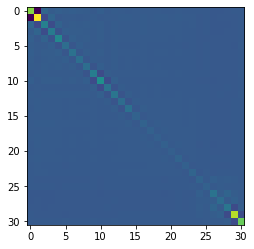

In [4]:
plt.imshow(syscov)

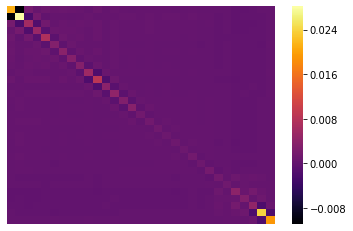

In [5]:
sns.heatmap(pd.DataFrame(syscov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')
plt.savefig("original_cov_binned_JLA.png", dpi=200)

In [6]:
np.min(np.abs(syscov)), np.max(np.abs(syscov)) #checking non-negatives in the diagonal

(1.695011341e-07, 0.02815552265)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [7]:
numMatrix = 1000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.normal() 
#     val, vec = np.linalg.eigh(syscov)
#     D = np.diag(val)    
#     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
    err = np.random.normal(size=syscov.shape) 
    covset[i] = syscov + 0.001 * err
    covset_noise[i] = syscov + 0.05 * err
#     covset_noise[i] = syscov + 0.001*err

 Generating 1000 matrix 

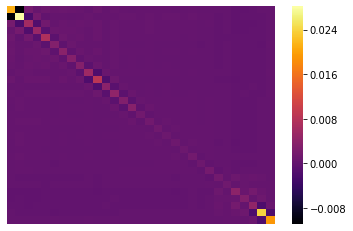

In [8]:
val, vec = np.linalg.eigh(syscov)
D = np.diag(val)
new = (vec+0.1) @ (D) @ (vec+0.1).T
sns.heatmap(pd.DataFrame(syscov), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

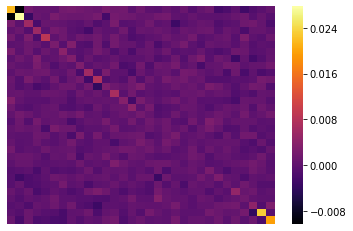

In [9]:
sns.heatmap(pd.DataFrame(covset[10]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

In [10]:
print(np.shape(covset))

(1000, 31, 31)


(1000, 31, 31)


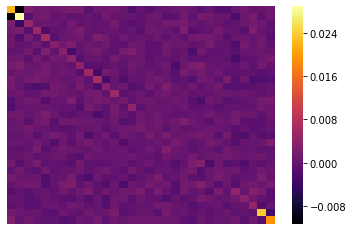

In [11]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [12]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(100, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(100, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               96200     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 31)                3131      
_________________________________________________________________
dropout_2 (Dropout)          (None, 31)               

In [13]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=500,
                batch_size=32,
                shuffle=True,
                validation_data=(covset_noise_test, covset_test),
                callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/500
25/25 [==============================] - 0s 8ms/step - loss: 8.0107e-04 - val_loss: 6.4596e-05
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 1.8131e-04 - val_loss: 1.8786e-05
Epoch 3/500
25/25 [==============================] - 0s 3ms/step - loss: 8.8967e-05 - val_loss: 9.7869e-06
Epoch 4/500
25/25 [==============================] - 0s 3ms/step - loss: 5.9764e-05 - val_loss: 6.1399e-06
Epoch 5/500
25/25 [==============================] - 0s 3ms/step - loss: 4.3541e-05 - val_loss: 4.5354e-06
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 3.3287e-05 - val_loss: 3.5053e-06
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 2.7935e-05 - val_loss: 2.8498e-06
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 2.2314e-05 - val_loss: 2.4852e-06
Epoch 9/500
25/25 [==============================] - 0s 3ms/step - loss: 1.9302e-05 - val_loss: 2.1134e-06
Epoch 10/500
25/25 [=================

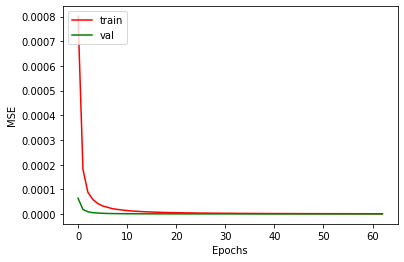

In [15]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLA.png', dpi=200)

In [16]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

1.0410310551378643e-06 1.7232938489541993e-06


In [17]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(200, 31)


(200, 961)


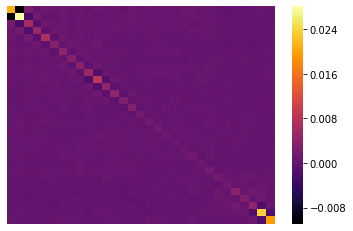

In [18]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


In [19]:
print(np.shape(decoded_imgs))

(200, 961)


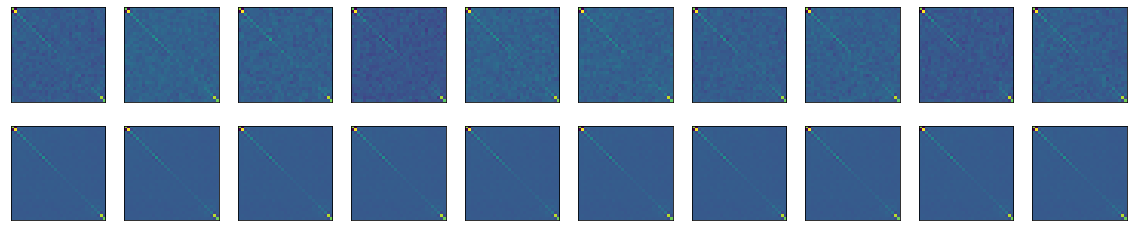

In [20]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(covset_test[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(31, 31))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

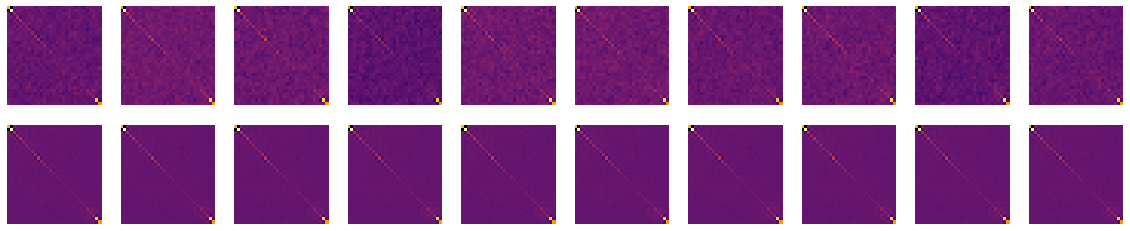

In [21]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we train another neural network for z and $D_L(z)$

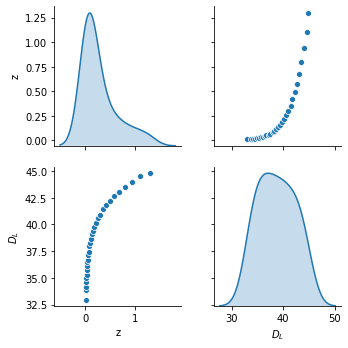

In [22]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
# print(data.head(31))
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistbinnedJLA.png")

In [23]:
shuffle = [x for x in range(len(data.values)) if x%2 == 0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]

In [24]:
z = data[:,0]
dl = data[:,1:]

In [25]:
# scalerz = StandardScaler()
# # scalerz = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scalerz.fit(z.reshape(-1,1))
# # apply transform
# z = scalerz.transform(z.reshape(-1,1))

In [26]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1, 1))
zz = scalerz.transform(z.reshape((-1,1)))
z_train, z_test = np.split(zz, indx)
dl_train, dl_test = np.split(dl, indx)

In [27]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=20,
                                   restore_best_weights=True)]

In [28]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(50, activation='relu')(efirst)
    x = Dense(50, activation='relu')(x)
    x = Dense(30, activation='relu')(x)

    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 1
epochs = 300
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 31        
Total params: 6,761
Trainable params: 6,761
Non-trainable params: 0
____________________________________________________

In [29]:
model_train = neural_model.fit(z_train, dl_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))
#                                     callbacks=callbacks)

Epoch 1/300
24/24 [==============================] - 0s 6ms/step - loss: 1425.9478 - val_loss: 1708.0496
Epoch 2/300
24/24 [==============================] - 0s 1ms/step - loss: 1347.1107 - val_loss: 1582.0159
Epoch 3/300
24/24 [==============================] - 0s 1ms/step - loss: 1079.6979 - val_loss: 1196.6140
Epoch 4/300
24/24 [==============================] - 0s 1ms/step - loss: 426.4310 - val_loss: 428.4336
Epoch 5/300
24/24 [==============================] - 0s 1ms/step - loss: 134.9583 - val_loss: 249.2505
Epoch 6/300
24/24 [==============================] - 0s 2ms/step - loss: 100.8917 - val_loss: 188.1075
Epoch 7/300
24/24 [==============================] - 0s 1ms/step - loss: 81.8805 - val_loss: 179.4109
Epoch 8/300
24/24 [==============================] - 0s 1ms/step - loss: 73.7381 - val_loss: 155.5426
Epoch 9/300
24/24 [==============================] - 0s 1ms/step - loss: 63.3909 - val_loss: 144.3997
Epoch 10/300
24/24 [==============================] - 0s 2ms/step - lo

24/24 [==============================] - 0s 2ms/step - loss: 1.1273 - val_loss: 0.9295
Epoch 83/300
24/24 [==============================] - 0s 2ms/step - loss: 0.9028 - val_loss: 0.7305
Epoch 84/300
24/24 [==============================] - 0s 2ms/step - loss: 1.0096 - val_loss: 0.4146
Epoch 85/300
24/24 [==============================] - 0s 2ms/step - loss: 0.8757 - val_loss: 0.3373
Epoch 86/300
24/24 [==============================] - 0s 2ms/step - loss: 0.8013 - val_loss: 0.5998
Epoch 87/300
24/24 [==============================] - 0s 1ms/step - loss: 0.7225 - val_loss: 0.2929
Epoch 88/300
24/24 [==============================] - 0s 2ms/step - loss: 0.8640 - val_loss: 1.3071
Epoch 89/300
24/24 [==============================] - 0s 2ms/step - loss: 0.9182 - val_loss: 0.3284
Epoch 90/300
24/24 [==============================] - 0s 2ms/step - loss: 0.7334 - val_loss: 0.8445
Epoch 91/300
24/24 [==============================] - 0s 2ms/step - loss: 1.3009 - val_loss: 2.5935
Epoch 92/300


24/24 [==============================] - 0s 2ms/step - loss: 0.5737 - val_loss: 0.1509
Epoch 164/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4470 - val_loss: 1.1977
Epoch 165/300
24/24 [==============================] - 0s 2ms/step - loss: 0.9742 - val_loss: 0.8955
Epoch 166/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4904 - val_loss: 0.2090
Epoch 167/300
24/24 [==============================] - 0s 1ms/step - loss: 0.6190 - val_loss: 0.3666
Epoch 168/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4656 - val_loss: 0.7823
Epoch 169/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4988 - val_loss: 0.1424
Epoch 170/300
24/24 [==============================] - 0s 2ms/step - loss: 0.4092 - val_loss: 0.1986
Epoch 171/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3543 - val_loss: 0.3195
Epoch 172/300
24/24 [==============================] - 0s 2ms/step - loss: 0.3985 - val_loss: 0.1838
Epoc

24/24 [==============================] - 0s 2ms/step - loss: 0.4725 - val_loss: 0.3287
Epoch 245/300
24/24 [==============================] - 0s 1ms/step - loss: 0.5401 - val_loss: 0.2184
Epoch 246/300
24/24 [==============================] - 0s 2ms/step - loss: 0.6631 - val_loss: 0.0821
Epoch 247/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2643 - val_loss: 0.3764
Epoch 248/300
24/24 [==============================] - 0s 1ms/step - loss: 0.2942 - val_loss: 1.4896
Epoch 249/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3297 - val_loss: 0.2160
Epoch 250/300
24/24 [==============================] - 0s 2ms/step - loss: 0.7042 - val_loss: 0.3655
Epoch 251/300
24/24 [==============================] - 0s 1ms/step - loss: 0.3793 - val_loss: 0.1057
Epoch 252/300
24/24 [==============================] - 0s 1ms/step - loss: 0.1841 - val_loss: 0.1405
Epoch 253/300
24/24 [==============================] - 0s 2ms/step - loss: 0.1910 - val_loss: 0.3795
Epoc

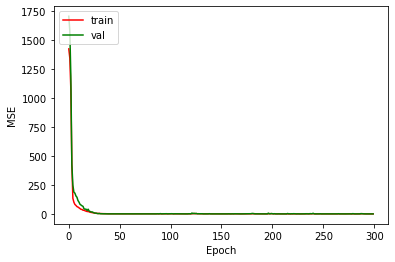

In [30]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_dlbinnedJla.png", dpi=200)

In [31]:
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet, np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])

(0.1653690368823585, 0.11463657766580582, 0.027346918359398842)

In [32]:
# pred = neural_model.predict(z_test)
# pred

In [33]:
# ranz = np.random.uniform(np.min(z), np.max(z), size=31)
ranz = np.linspace(np.min(z), np.max(z), 31)
ranzz = scalerz.transform(ranz.reshape((-1,1)))

# ranzinv = scalerz.transform(ranz.reshape(-1,1))

pred_random = neural_model.predict(ranzz)
# pred_random

In [34]:
# recover z
# z = scalerz.inverse_transform(z)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [35]:
fake_encoded = np.zeros((1, 31))

In [36]:
print(np.shape(fake_encoded))
avg_encoded = np.mean(encoded_imgs, axis=0)
print(np.shape(avg_encoded))
print(np.shape(encoded_imgs))
print(type(encoded_imgs))


(1, 31)
(31,)
(200, 31)
<class 'numpy.ndarray'>


In [37]:
for i, avg in enumerate(avg_encoded):
    alpha = avg/zz[i]
    fake_encoded[0, i] = alpha * ranzz[i]

In [38]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

In [39]:
# decoded_fake[0, :]

1.3747558e-07

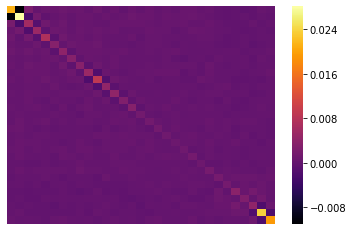

In [40]:
sns.heatmap(pd.DataFrame(decoded_fake[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
plt.savefig('fake_cov_jla.png', dpi=200)
np.min(np.abs(decoded_fake[0, :]))

-0.01084098704 0.02815552265 0.00039265133851975654
-0.0109343035 0.028087633 0.00039638433
-0.010918329 0.028066253 0.00039707404


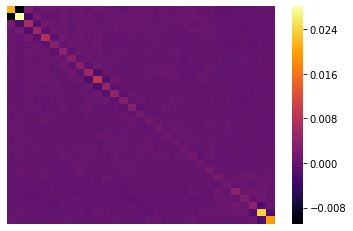

In [41]:
clean_img = autoencoder.predict(decoded_fake[0, :].reshape(1,-1))
sns.heatmap(pd.DataFrame(clean_img[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
plt.savefig('fake_cov_clean_jla.png', dpi=200)
np.min(np.abs(clean_img[0, :]))

print(np.min(syscov), np.max(syscov), np.mean(syscov)) #checking non-negatives in the diagonal
print(np.min(decoded_fake[0,:]), np.max(decoded_fake[0,:]), np.mean(decoded_fake[0,:])) #checking non-negatives in the diagonal
print(np.min(clean_img[0,:]), np.max(clean_img[0,:]), np.mean(clean_img[0,:])) #checking non-negatives in the diagonal



In [42]:
np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
np.savetxt("fake_binned_JLA_COVdecodedclean.dat", clean_img[0, :].reshape(31,31), delimiter= " ", header="#fake COV")

In [43]:
count = 0
new_cov =decoded_fake[0, :].reshape(31,31)

for i in range(len(new_cov)):
    for j in range(len(new_cov)):
        if np.iscomplex(new_cov[i,j]):
            print("COMPLEX")
        if new_cov[i,j] != new_cov[j,i]:
#             print(i,j, end=' ')
#             print(new_cov[i,j], new_cov[j,i]) 
            count+=1
            new_cov[j,i] = new_cov[i, j]

count

465

In [44]:
np.savetxt("fake_binned_JLA_COVdecodedsim.dat", new_cov, delimiter= " ", header="#fake COV")

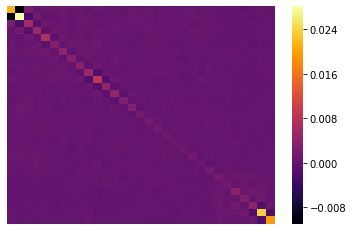

In [45]:
sns.heatmap(pd.DataFrame(new_cov), fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [46]:
fake_data = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
np.savetxt("fake_binned_JLA.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu")

In [47]:
errors = np.sqrt(np.abs(np.diagonal(syscov)))
fakeerrors = np.sqrt(np.abs(np.diagonal(decoded_fake.reshape(31,31))))
np.max(errors), np.max(fakeerrors)

(0.1677960745965173, 0.16759366)

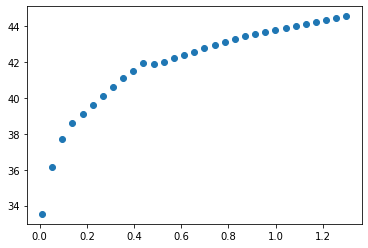

In [48]:
plt.scatter(ranz, pred_random)

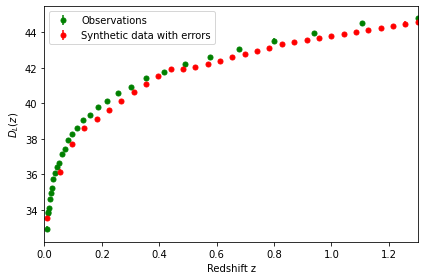

In [49]:
plt.errorbar(z, dl, yerr=errors, fmt='g.', markersize=10, label='Observations')
plt.errorbar(ranz, pred_random, 
             yerr=fakeerrors, fmt='r.', markersize=10., label='Synthetic data with errors')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
plt.xlim(0, np.max(z))
plt.tight_layout()
plt.legend()
# plt.savefig('fake_vs_binned_jla.png', dpi=200)

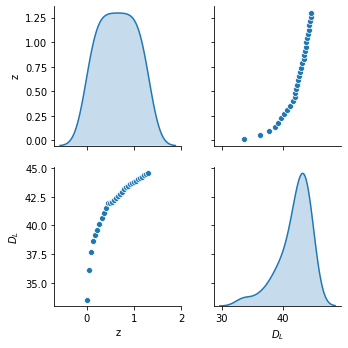

In [50]:
fake_datadf = pd.DataFrame(fake_data, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf, diag_kind="kde")
plt.savefig('fake_binned_jla.png')

In [213]:
# Guardar modelos
# autoencoder.save('autoencoderJLA.h5')
# decoder.save('decoderJLA.h5')
# neural_model.save('FFNN_JLA.h5')

### NOW we use dropout as uncertainty estimator

In [511]:
from astroNN.nn.layers import MCDropout

In [512]:
# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img2 = tf.keras.Input(shape=(31*31,))
# begin encoder
x2 = layers.Dense(100, activation='tanh')(input_img2)
x2 = MCDropout(0.02)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.02)(x2)
encoded2 = layers.Dense(encoding_dim, activation='tanh')(x2)
x2 = MCDropout(0.02)(encoded2)
#begin decoder
x2 = layers.Dense(100, activation='tanh')(x2)
x2 = MCDropout(0.02)(x2)
x2 = layers.Dense(100, activation='tanh')(x2)
# x2 = MCDropout(0.02)(x2)
decoded2 = layers.Dense(31*31, activation='linear')(x2)


# This model maps an input to its reconstruction
autoencoder2 = tf.keras.Model(input_img2, decoded2)
autoencoder2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder2.summary()

Model: "functional_165"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 961)]             0         
_________________________________________________________________
dense_221 (Dense)            (None, 100)               96200     
_________________________________________________________________
MCDropout_161 (MCDropout)    (None, 100)               0         
_________________________________________________________________
dense_222 (Dense)            (None, 100)               10100     
_________________________________________________________________
MCDropout_162 (MCDropout)    (None, 100)               0         
_________________________________________________________________
dense_223 (Dense)            (None, 31)                3131      
_________________________________________________________________
MCDropout_163 (MCDropout)    (None, 31)             

In [513]:
# optimizer = Adam(lr=.005)
# optimizer = Adam(lr=0.0001)


autoencoder2_train = autoencoder2.fit(covset_noise_train, covset_train,
                    epochs=500,
                    batch_size=31,
                    shuffle=True,
                    validation_data=(covset_noise_test, covset_test),
                    callbacks=callbacks)

Epoch 1/500
26/26 [==============================] - 0s 11ms/step - loss: 2.7963e-04 - val_loss: 8.2718e-05
Epoch 2/500
26/26 [==============================] - 0s 4ms/step - loss: 4.0825e-05 - val_loss: 3.3322e-05
Epoch 3/500
26/26 [==============================] - 0s 4ms/step - loss: 1.9029e-05 - val_loss: 2.0576e-05
Epoch 4/500
26/26 [==============================] - 0s 5ms/step - loss: 1.2199e-05 - val_loss: 1.4859e-05
Epoch 5/500
26/26 [==============================] - 0s 5ms/step - loss: 8.9633e-06 - val_loss: 1.1600e-05
Epoch 6/500
26/26 [==============================] - 0s 5ms/step - loss: 6.9474e-06 - val_loss: 9.5246e-06
Epoch 7/500
26/26 [==============================] - 0s 5ms/step - loss: 5.6833e-06 - val_loss: 7.9723e-06
Epoch 8/500
26/26 [==============================] - 0s 4ms/step - loss: 4.7248e-06 - val_loss: 6.7619e-06
Epoch 9/500
26/26 [==============================] - 0s 4ms/step - loss: 4.1672e-06 - val_loss: 5.8121e-06
Epoch 10/500
26/26 [================

Epoch 77/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1715e-06 - val_loss: 1.3896e-06
Epoch 78/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1687e-06 - val_loss: 1.4515e-06
Epoch 79/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1681e-06 - val_loss: 1.4520e-06
Epoch 80/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1649e-06 - val_loss: 1.4304e-06
Epoch 81/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1815e-06 - val_loss: 1.3950e-06
Epoch 82/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1635e-06 - val_loss: 1.3927e-06
Epoch 83/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1618e-06 - val_loss: 1.3914e-06
Epoch 84/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1572e-06 - val_loss: 1.3705e-06
Epoch 85/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1439e-06 - val_loss: 1.3729e-06
Epoch 86/500
26/26 [========

26/26 [==============================] - 0s 4ms/step - loss: 1.1002e-06 - val_loss: 1.2004e-06
Epoch 153/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0984e-06 - val_loss: 1.2097e-06
Epoch 154/500
26/26 [==============================] - 0s 4ms/step - loss: 1.1021e-06 - val_loss: 1.2264e-06
Epoch 155/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0973e-06 - val_loss: 1.2227e-06
Epoch 156/500
26/26 [==============================] - 0s 5ms/step - loss: 1.0959e-06 - val_loss: 1.2030e-06
Epoch 157/500
26/26 [==============================] - 0s 5ms/step - loss: 1.0911e-06 - val_loss: 1.1967e-06
Epoch 158/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0966e-06 - val_loss: 1.2137e-06
Epoch 159/500
26/26 [==============================] - 0s 5ms/step - loss: 1.0973e-06 - val_loss: 1.2053e-06
Epoch 160/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0898e-06 - val_loss: 1.1956e-06
Epoch 161/500
26/26 [============

26/26 [==============================] - 0s 5ms/step - loss: 1.0758e-06 - val_loss: 1.1433e-06
Epoch 228/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0706e-06 - val_loss: 1.1520e-06
Epoch 229/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0703e-06 - val_loss: 1.1608e-06
Epoch 230/500
26/26 [==============================] - 0s 5ms/step - loss: 1.0725e-06 - val_loss: 1.1436e-06
Epoch 231/500
26/26 [==============================] - 0s 5ms/step - loss: 1.0750e-06 - val_loss: 1.1468e-06
Epoch 232/500
26/26 [==============================] - 0s 5ms/step - loss: 1.0723e-06 - val_loss: 1.1553e-06
Epoch 233/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0725e-06 - val_loss: 1.1598e-06
Epoch 234/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0718e-06 - val_loss: 1.1453e-06
Epoch 235/500
26/26 [==============================] - 0s 4ms/step - loss: 1.0721e-06 - val_loss: 1.1607e-06
Epoch 236/500
26/26 [============

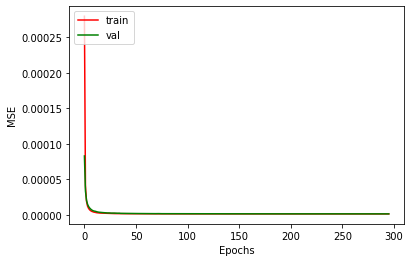

In [514]:
plt.plot(autoencoder2_train.history['loss'], color='r', )
plt.plot(autoencoder2_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_binned_JLAdropout.png', dpi=200)

In [515]:
encoder2 = tf.keras.Model(input_img2, encoded2)
# This is our encoded (32-dimensional) input
encoded2_input = tf.keras.Input(shape=(encoding_dim,))

decoder2_layer1 = autoencoder2.layers[-5]
decoder2_layer2 = autoencoder2.layers[-4]
decoder2_layer3 = autoencoder2.layers[-3]
decoder2_layer4 = autoencoder2.layers[-2]
decoder2_layer5 = autoencoder2.layers[-1]

# create the decoder model
decoder2 = Model(encoded2_input, 
                decoder2_layer5(decoder2_layer4(decoder2_layer3(decoder2_layer2(decoder2_layer1(encoded2_input))))))

In [516]:
decoder2.summary()

Model: "functional_169"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 31)]              0         
_________________________________________________________________
MCDropout_163 (MCDropout)    (None, 31)                0         
_________________________________________________________________
dense_224 (Dense)            (None, 100)               3200      
_________________________________________________________________
MCDropout_164 (MCDropout)    (None, 100)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_226 (Dense)            (None, 961)               97061     
Total params: 110,361
Trainable params: 110,361
Non-trainable params: 0
______________________________________________

In [517]:
# Generate test data
test_batch_size = 31*31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0, 2., test_batch_size)
print(np.shape(fake_encoded))
mc_dropout_num = 100  # Run Dropout 100 times
predictions_dec = np.zeros((mc_dropout_num, 1, test_batch_size))
uncertainty = np.zeros((mc_dropout_num, 1, test_batch_size))
for i in range(mc_dropout_num):
    predictions_dec[i] = decoder2.predict(fake_encoded)
    
# get mean results and its varience
prediction_mc_dropout_dec = np.mean(predictions_dec, axis=0, dtype=np.float64)
std_mc_dropout_dec = np.std(predictions_dec, axis=0, dtype=np.float64)
np.shape(prediction_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(1, 31)


((1, 961), (1, 961))

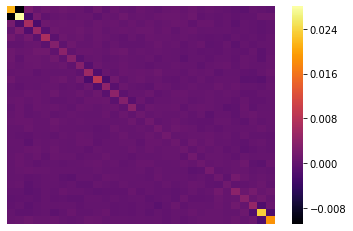

In [518]:
sns.heatmap(pd.DataFrame(prediction_mc_dropout_dec[0, :].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [519]:
np.mean(std_mc_dropout_dec), np.shape(std_mc_dropout_dec)

(8.6198260967423e-05, (1, 961))

In [520]:
def model2_dropout(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = MCDropout(0.1)(efirst)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(50, activation='relu')(x)
    x = MCDropout(0.1)(x)
    x = Dense(30, activation='relu')(x)
    x = MCDropout(0.1)(x)
    elast = Dense(1, activation='linear')(x)
    return elast

batch_size = 4
epochs = 200
input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2_dropout(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "functional_171"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 1)]               0         
_________________________________________________________________
dense_227 (Dense)            (None, 50)                100       
_________________________________________________________________
MCDropout_165 (MCDropout)    (None, 50)                0         
_________________________________________________________________
dense_228 (Dense)            (None, 50)                2550      
_________________________________________________________________
MCDropout_166 (MCDropout)    (None, 50)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 50)                2550      
_________________________________________________________________
MCDropout_167 (MCDropout)    (None, 50)             

In [521]:
model2_train = neural_model2.fit(z_train, dl_train, batch_size=1,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, dl_test))

Epoch 1/200
24/24 [==============================] - 0s 8ms/step - loss: 1417.2584 - val_loss: 1693.4725
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 1308.6749 - val_loss: 1525.9510
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 965.2391 - val_loss: 1039.2626
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 328.1271 - val_loss: 294.5410
Epoch 5/200
24/24 [==============================] - 0s 3ms/step - loss: 119.2764 - val_loss: 280.7037
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 118.2884 - val_loss: 172.3878
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 70.8052 - val_loss: 152.4763
Epoch 8/200
24/24 [==============================] - 0s 3ms/step - loss: 59.1095 - val_loss: 211.0860
Epoch 9/200
24/24 [==============================] - 0s 3ms/step - loss: 78.3723 - val_loss: 149.7986
Epoch 10/200
24/24 [==============================] - 0s 3ms/step - los

24/24 [==============================] - 0s 2ms/step - loss: 18.5552 - val_loss: 19.9030
Epoch 82/200
24/24 [==============================] - 0s 2ms/step - loss: 16.1611 - val_loss: 35.0892
Epoch 83/200
24/24 [==============================] - 0s 2ms/step - loss: 18.6605 - val_loss: 27.9568
Epoch 84/200
24/24 [==============================] - 0s 3ms/step - loss: 24.2177 - val_loss: 39.9587
Epoch 85/200
24/24 [==============================] - 0s 3ms/step - loss: 28.9705 - val_loss: 14.4364
Epoch 86/200
24/24 [==============================] - 0s 2ms/step - loss: 17.1637 - val_loss: 43.6794
Epoch 87/200
24/24 [==============================] - 0s 2ms/step - loss: 19.0754 - val_loss: 42.7792
Epoch 88/200
24/24 [==============================] - 0s 2ms/step - loss: 16.0648 - val_loss: 13.5363
Epoch 89/200
24/24 [==============================] - 0s 2ms/step - loss: 14.7900 - val_loss: 30.5326
Epoch 90/200
24/24 [==============================] - 0s 2ms/step - loss: 37.0640 - val_loss: 3

Epoch 161/200
24/24 [==============================] - 0s 3ms/step - loss: 28.8854 - val_loss: 27.8635
Epoch 162/200
24/24 [==============================] - 0s 2ms/step - loss: 10.8727 - val_loss: 25.9879
Epoch 163/200
24/24 [==============================] - 0s 2ms/step - loss: 17.5419 - val_loss: 23.2702
Epoch 164/200
24/24 [==============================] - 0s 2ms/step - loss: 21.8737 - val_loss: 32.2311
Epoch 165/200
24/24 [==============================] - 0s 2ms/step - loss: 17.2734 - val_loss: 25.2103
Epoch 166/200
24/24 [==============================] - 0s 3ms/step - loss: 18.7175 - val_loss: 16.6153
Epoch 167/200
24/24 [==============================] - 0s 2ms/step - loss: 17.1185 - val_loss: 36.5079
Epoch 168/200
24/24 [==============================] - 0s 2ms/step - loss: 32.5989 - val_loss: 21.2641
Epoch 169/200
24/24 [==============================] - 0s 2ms/step - loss: 18.8497 - val_loss: 14.1199
Epoch 170/200
24/24 [==============================] - 0s 4ms/step - loss

In [524]:
neural_model2.predict(ranzz)

array([[33.855625],
       [34.003204],
       [30.327269],
       [43.902412],
       [35.238598],
       [33.546078],
       [34.425457],
       [37.73987 ],
       [42.36036 ],
       [43.08165 ],
       [45.055473],
       [42.364185],
       [46.793377],
       [38.222298],
       [47.063255],
       [35.20203 ],
       [38.18838 ],
       [48.34193 ],
       [41.978176],
       [38.087883],
       [40.868362],
       [34.453896],
       [50.413956],
       [43.124146],
       [47.66734 ],
       [49.319855],
       [43.584255],
       [38.996937],
       [45.151268],
       [44.75971 ],
       [47.452465]], dtype=float32)

In [526]:
# Generate test data
# test_batch_size = 31
# x_test = np.random.uniform(0, np.max(z), test_batch_size)
# x_test = np.linspace(0.01, np.max(z), test_batch_size)
# Generate test data
test_batch_size = 31
# x_test = np.random.uniform(np.min(z), np.max(z), test_batch_size)
x_test = np.linspace(np.min(z), np.max(z), test_batch_size)

mc_dropout_num = 50  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 1))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = neural_model2.predict(scalerz.transform(x_test.reshape(-1,1)))
    

# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

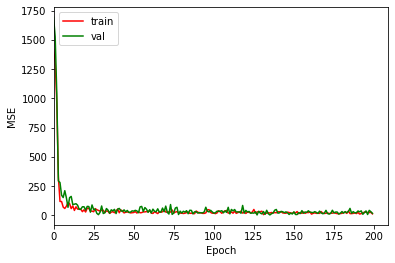

In [527]:
plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
# plt.xscale('log')
plt.xlim(0)
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss_dropoutJLA.png', dpi=100)

In [528]:
np.mean(std_mc_dropout)

4.941149021223636

In [529]:
Om = 0.27
# variance network
w0 = -1

def RHSquared_a_lcdm(a):
#         return Ezlcdm(a)**2
    return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, model, w0, wa):
        if model == 'lcdm':
            return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
        elif model == 'owacdm':
            return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, model, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(model, w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, model='lcdm', w0=-1, wa=0.5):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, model, w0, wa)*(1+z))+43

In [530]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz))
#     fowacdm1.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.5))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

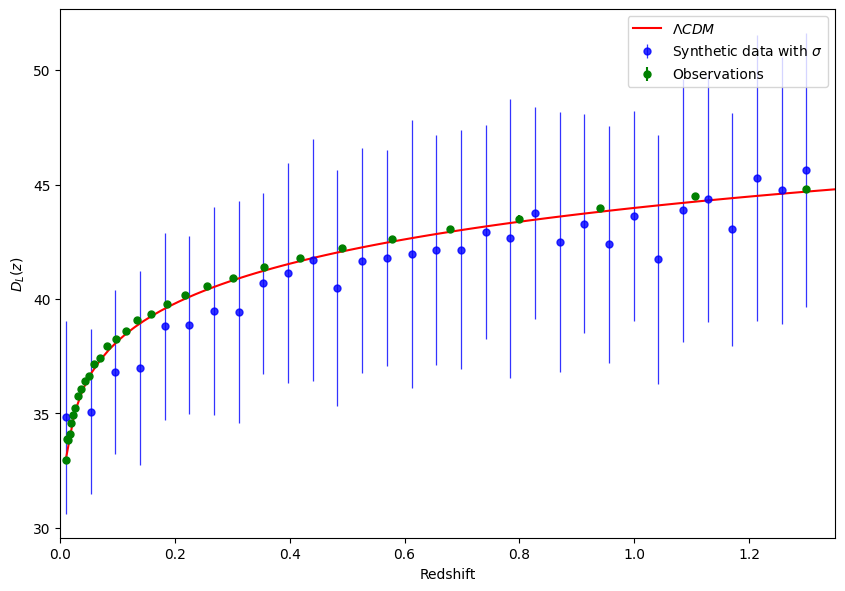

In [531]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)

fakeerrors2 = np.sqrt(np.abs(np.diagonal(prediction_mc_dropout_dec .reshape(31,31))))

std_dropout_diag = np.sqrt(np.abs(np.diagonal(std_mc_dropout_dec.reshape(31,31))))

sigma = np.sqrt(std_mc_dropout.reshape(31,)**2 + fakeerrors2 + std_dropout_diag**2)

plt.errorbar(ranz, prediction_mc_dropout, yerr=sigma
             , markersize=10, fmt='.', 
             ecolor='blue', capthick=2, elinewidth=0.9, alpha=0.8, c='b',
             label='Synthetic data with $\sigma$')

# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.errorbar(z, dl, errors, fmt='g.', markersize=10, label='Observations')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='r')
# plt.plot(zmodel, fowacdm1, label='$\omega_0\omega_aCDM \;\; \omega_a=0.5$', c='m')
# plt.plot(zmodel, fowacdm2, label='$\omega_0\omega_aCDM \;\; \omega_a=-0.5$', c='y')
# plt.plot(zmodel, Hlcdm(zmodel), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(zmodel, Hlcdm(zmodel, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlim(0, np.max(z)+0.05)
plt.xlabel('Redshift')
plt.ylabel('$D_L(z)$')
# plt.legend(loc='best')
plt.legend(loc='upper right')
# plt.show()
plt.savefig('DL_dropout5.png', dpi=200)

In [533]:
np.savetxt("fake_binned_JLA_COVdecodedDO.dat", prediction_mc_dropout_dec[0, :].reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

In [534]:
x_test

array([0.01 , 0.053, 0.096, 0.139, 0.182, 0.225, 0.268, 0.311, 0.354,
       0.397, 0.44 , 0.483, 0.526, 0.569, 0.612, 0.655, 0.698, 0.741,
       0.784, 0.827, 0.87 , 0.913, 0.956, 0.999, 1.042, 1.085, 1.128,
       1.171, 1.214, 1.257, 1.3  ])

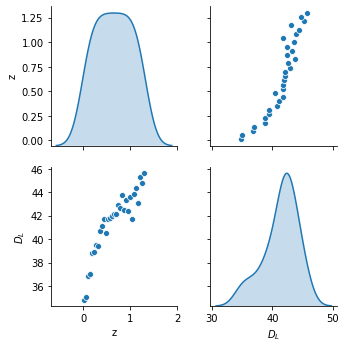

In [535]:
fake_datadf2 = pd.DataFrame(fake_data2, columns=['z', '$D_L$'])
sns.pairplot(fake_datadf2, diag_kind="kde")
plt.savefig('fake_binned_jla22DO.png')

In [536]:
clean_img = autoencoder2.predict(prediction_mc_dropout_dec[0, :].reshape(1,-1))
# prediction_mc_dropout_dec[0, :].reshape(31,31)

In [537]:
np.savetxt("fake_binned_JLA_COVdecodedDOclean.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")
fake_data2 = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)
# np.savetxt("fake_binned_JLADO.dat",  fake_data2, delimiter= " ", header="#fake data\n# z\n# mu")

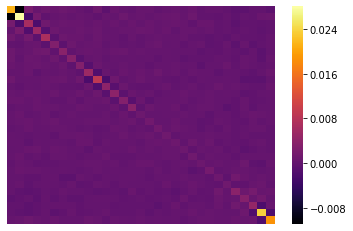

In [538]:
sns.heatmap(pd.DataFrame(clean_img.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [539]:
clean_img = autoencoder2.predict(clean_img)


In [540]:
# prediction_mc_dropout_dec[0, :].reshape(31,31)
np.savetxt("fake_binned_JLA_COVdecodedDOclean2.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")

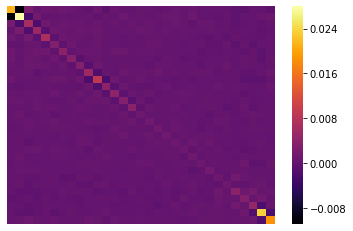

In [541]:
sns.heatmap(pd.DataFrame(clean_img.reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)

In [542]:
autoencoder2.save('autoencoderJLA_DO.h5')
decoder2.save('decoderJLA_DO.h5')
neural_model2.save('FFNN_JLA_DO.h5')